# Denoising Diffusion Model from Scratch - Explanation

In this notebook, I will build a simpler model from the Denoising Diffusion Probabilistic Model Paper. I will use the MNIST dataset. The formulas will be displayed throughout the notebook. The derivations of each of these formulas can be found in the PDF within the GitHub Repo.

The paper link: https://arxiv.org/abs/2006.11239


## 1. Dataset - MNIST

In [1]:
# Imports
import math
import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.optim import Adam

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 28227129.79it/s]


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 843880.66it/s]


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 4191942.20it/s]


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 9154506.86it/s]

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



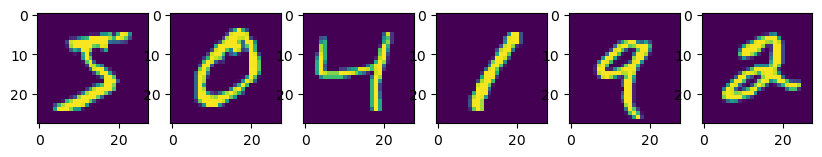

In [2]:
def show_images(datset, num_samples=6, cols=6):
    """ Explore images from the dataset """
    plt.figure(figsize=(10,10))
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

data = torchvision.datasets.MNIST(root=".", download=True) # 60k images
show_images(data)

## 2. Build Diffusion Model

### 2.1 Forward Process - Noise Scheduler

We need to build the inputs to the model. These inputs are noisy images. Originally, adding noise to images was done in an sequential process. However, the authors manipulated the forward process equation to compute the noisy image in one step for any timestep $t$. This can be done because the sum of Gaussians is also Gaussian. Let \\(q(\mathbf{x}_0)\\) be the real data distribution of the "real images." We will sample from this distribution to get an new image, \\(\mathbf{x}_0 \sim q(\mathbf{x}_0)\\). The forward process is displayed below. The forward process adds Gaussian noise at each time step $t$ to a known variance schedule \\(0 < \beta_1 < \beta_2 < ... < \beta_T < 1\\).

\
Let $\alpha_t=1-\beta_t$ \
Let $\bar{\alpha}_t=\prod_{i=1}^t \alpha_i$

\
$$q\left(x_t \mid x_{t-1}\right) = \mathcal{N}\left(x_t, \sqrt{1-\beta_t} x_{t-1}, \beta_t I\right)$$
\
The derivation of this equation is in the analysis document in the repository. After derving this equation, the code will implement this line:

$$ q\left(\mathbf{x}_{t} \mid \mathbf{x}_{0}\right) = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$$



**Key Points**
 - The noise levels/variances can be pre-computed to help computing cost.
 - There are different variance schedules. The authors use a linear or quadratic. However, later papers improve the variance schedule. They use a cosine schedule.

In [3]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
  return torch.linspace(start, end, timesteps)

def quadratic_beta_schedule(timesteps, start=0.0001, end=0.02):
  return torch.linspace(start**0.5, end**0.5, timesteps) ** 2

In [4]:
def get_index_from_list(vals, t, x_shape):
  # Return a specific index t of a passed list of values vals while
  # considering the batch dimension
  batch_size = t.shape[0]
  out = vals.gather(-1, t.cpu()) ## this is different
  return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)
  # return out

def forward_diffusion_sample(x_0, t, device="cpu"):
    """
    Return noisy image with random timestep
    """
    ## generate random noise with the same shape as x_0
    noise = torch.randn_like(x_0)

    # Cumulative product of of alphas starting at timestep t
    # Part of the mean term
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)

    # Variance term
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )

    # Return the mean + variance and noise
    # From equation above
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule -- Original was 1000 steps
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas

# Cumulative Product of all alphas
alphas_cumprod = torch.cumprod(alphas, axis=0)

# First position is 1.0
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

# Take square root of cumulative product of alphas
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)

# Calculat noise coefficient
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# Need this for sampling
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [5]:
BATCH_SIZE = 128
IMG_SIZE = 28

def load_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # Scales data into [0, 1]
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1]
    ]

    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.MNIST(root=".", download=True, train=True,
                                         transform=data_transform)
    test = torchvision.datasets.MNIST(root=".", download=True, train=False,
                                         transform=data_transform)
    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2), ## back to [0, 1]
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC -- change switch order
        transforms.Lambda(lambda t: t * 255.), # back to [0, 255]
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Get first image in batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

data = load_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

C:\Users\baseb\AppData\Local\Temp\ipykernel_47788\1509478405.py:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


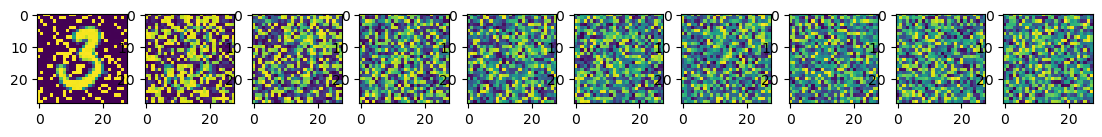

In [6]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

### 2.2 The Backward Process - U-Net Model

I implement a U-Net model because the inputs and outputs have the same dimensions (image dimensions). The U-Net predicts the amount of noise in the image. The input is a noisy image, and the output is the noise in the image. Within the model, the parameters are shared. The model needs to know which timestep the model is on. The timestep is encoded using a sinusodial embedding. I simplified the U-Net the model for efficiency purposes.



In [7]:
class SinusodialPosEmbedding(nn.Module):
  def __init__(self, dim):
    super().__init__()
    self.dim = dim

  def forward(self, time):
    device = time.device
    half_dim = self.dim // 2
    embeddings = math.log(10000) / (half_dim - 1)
    embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
    embeddings = time[:, None] * embeddings[None, :]
    embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
    return embeddings

In [8]:
class Block(nn.Module):
  def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
    super().__init__()
    self.time_mlp = nn.Linear(time_emb_dim, out_ch)

    ## Two convolutions
    if up:
      self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
      self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
    else:
      self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
      self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)

    self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)

    # Group normalization and ReLU
    self.gnorm1 = nn.GroupNorm(1, out_ch)
    self.gnorm2 = nn.GroupNorm(1, out_ch)
    self.relu =  nn.ReLU()


  def forward(self, x, t, ):
    # First Conv
    h = self.gnorm1(self.relu(self.conv1(x)))
    # Time embedding
    time_emb = self.relu(self.time_mlp(t))
    # Extend last 2 dimensions
    time_emb = time_emb[(..., ) + (None, ) * 2]
    # Add time channel
    h = h + time_emb
    # Second Conv

    h = self.gnorm2(self.relu(self.conv2(h)))
    # Down or Upsample
    return self.transform(h)

In [9]:
class uNet(nn.Module):
  def __init__(self):
    super().__init__()
    image_ch = 1
    down_ch = (28, 128, 256, 512, 1024)
    up_ch = (1024, 512, 256, 128, 28)
    out_dim = 1
    time_emb_dim = 32

    # Time embedding
    self.time_mlp = nn.Sequential(
        SinusodialPosEmbedding(time_emb_dim),
        nn.Linear(time_emb_dim, time_emb_dim),
        nn.ReLU()
    )

    self.conv0 = nn.Conv2d(image_ch, down_ch[0], 3, padding=1)

    # Downsample
    down_blocks = []
    for i in range(len(down_ch) - 1):
      temp_block = Block(down_ch[i], down_ch[i + 1], time_emb_dim)
      down_blocks.append(temp_block)

    self.downs = nn.ModuleList(down_blocks)

    # Upsample
    up_blocks = []
    for i in range(len(up_ch) - 1):
      temp_block = Block(up_ch[i], up_ch[i + 1], time_emb_dim, up=True)
      up_blocks.append(temp_block)

    self.ups = nn.ModuleList(up_blocks)
    self.output = nn.Conv2d(up_ch[-1], out_dim, 1)

  def forward(self, x, timestep):
      # Embedd time and initial convolution
      t = self.time_mlp(timestep)
      x = self.conv0(x)

      residual_inputs = []
      for down in self.downs:
          x = down(x, t)
          residual_inputs.append(x)

      for up in self.ups:
          # Make sure the dimensions line up
          residual_x = residual_inputs.pop()
          if x.size(2) != residual_x.size(2) or x.size(3) != residual_x.size(3):
              x = F.interpolate(x, size=(residual_x.size(2), residual_x.size(3)), mode='bilinear', align_corners=False)
          x = torch.cat((x, residual_x), dim=1)
          x = up(x, t)
      return self.output(x)


model = uNet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
# model

Num params:  62228549


### 2.3 Loss Function

In [10]:
def get_loss(model, x_0, t, loss_type):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)

    if loss_type == 'l1':
      loss = F.l1_loss(noise, noise_pred)
    elif loss_type == 'l2':
      loss = F.mse_loss_loss(noise, noise_pred)
    else:
      raise NotImplementedError()

    return loss


## 2.4 Sampling

We will sample from the model during training to track progress of the model. The sampling algorithm is show below from the paper:

<p align="center">
    <img src='https://github.com/CamdenKitowski/DenoisingDiffusionModels/blob/main/images/algo1.png?raw=true' width="500" />
</p>


We sample new images by reversing the diffusion process. We start from the $T$ until we end at time step $t = 0$. We start from pure noise from a Gaussian distribution, and then the U-Net gradually denoises the image using the conditional probability it has learned. Ideally, the final image looks like it came from the real data distribution.


We will use equation 11 within the paper to predict the mean.

$$\boldsymbol{\mu}_{\theta}\left(\mathbf{x}_{t}, t\right)=\tilde{\boldsymbol{\mu}}_{t}\left(\mathbf{x}_{t}, \frac{1}{\sqrt{\bar{\alpha}_{t}}}\left(\mathbf{x}_{t}-\sqrt{1-\bar{\alpha}_{t}} \boldsymbol{\epsilon}_{\theta}\left(\mathbf{x}_{t}\right)\right)\right)=\frac{1}{\sqrt{\alpha_{t}}}\left(\mathbf{x}_{t}-\frac{\beta_{t}}{\sqrt{1-\bar{\alpha}_{t}}} \boldsymbol{\epsilon}_{\theta}\left(\mathbf{x}_{t}, t\right)\right)$$


<!-- <img src="content/algo2.png" width="500" /> -->


In [11]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Predict the noise in the image and return denoised image
    """
    # Equation 11
    # Get all the betas for current time step
    betas_t = get_index_from_list(betas, t, x.shape)

    # Denominator within the parentheses
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )

    # Coefficient
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Use model to get mean (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    # Algorithm line 4
    if t == 0:
        # does not apply noise
        return model_mean
    else:
        posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def plot_sample():
    """
    Plot images in training from isotropic noise (left) to new sampled
    image (right)
    """
    img_size = IMG_SIZE
    img = torch.randn((1, 1, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    # Algorith 2 loop
    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        # plot images
        if i % stepsize == 0:
            index = num_images - int(i / stepsize)
            plt.subplot(1, num_images, index)
            show_tensor_image(img.detach().cpu())
    plt.show()

### 2.5 Train Model

From reparameterization of the KL terms in the loss function, the neural network will learn the added noise for the noise level $t$. The neural network will predict the amount of noise. The neural network does need to the predict the mean. The original loss function was comprised of three terms.


$ \mathbb{E}_{q}\left[\underbrace{D_{\mathrm{KL}}\left(q\left(\mathbf{x}_{T} \mid \mathbf{x}_{0}\right) \| p\left(\mathbf{x}_{T}\right)\right)}_{L_{T}}+\sum_{t=2}^T \underbrace{D_{\mathrm{KL}}\left(q\left(\mathbf{x}_{t-1} \mid \mathbf{x}_{t}, \mathbf{x}_{0}\right) \| p_{\theta}\left(\mathbf{x}_{t-1} \mid \mathbf{x}_{t}\right)\right)}_{L_{t-1}} \underbrace{-\log p_{\theta}\left(\mathbf{x}_{0} \mid \mathbf{x}_{1}\right)}_{L_{0}}\right]$


After reparameterization of this equation, the final objective function is a simple MSE loss function with the predicted noise and actual noise. The equation is down below.

$$ \| \mathbf{\epsilon} - \mathbf{\epsilon}_\theta(\mathbf{x}_t, t) \|^2 = \| \mathbf{\epsilon} - \mathbf{\epsilon}_\theta( \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{(1- \bar{\alpha}_t)  } \mathbf{\epsilon}, t) \|^2.$$


Using this loss function, we can look at the full training algorithm.

<p align="center">
    <img src='https://github.com/CamdenKitowski/DenoisingDiffusionModels/blob/main/images/algo2.png?raw=true' width="500" />
</p>

Epoch 0 | Loss: 0.8166275024414062 


C:\Users\baseb\AppData\Local\Temp\ipykernel_47788\1333141922.py:54: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, index)


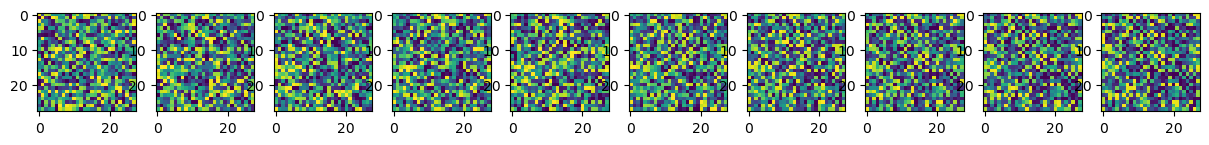

Epoch 1/100, Loss: 0.18895704226889015
Epoch 2/100, Loss: 0.12233781653555321
Epoch 3/100, Loss: 0.11277033106147588
Epoch 4/100, Loss: 0.10557132625044921
Epoch 5/100, Loss: 0.10002081601065158
Epoch 5 | Loss: 0.09532608836889267 


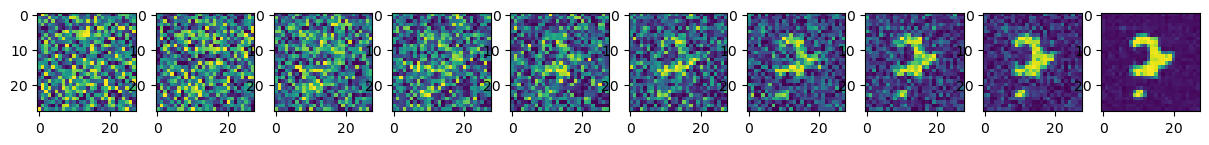

Epoch 6/100, Loss: 0.0954869524490484
Epoch 7/100, Loss: 0.09268461308363593
Epoch 8/100, Loss: 0.089744752962074
Epoch 9/100, Loss: 0.08715058732163775
Epoch 10/100, Loss: 0.08573782980278298
Epoch 10 | Loss: 0.08052574843168259 


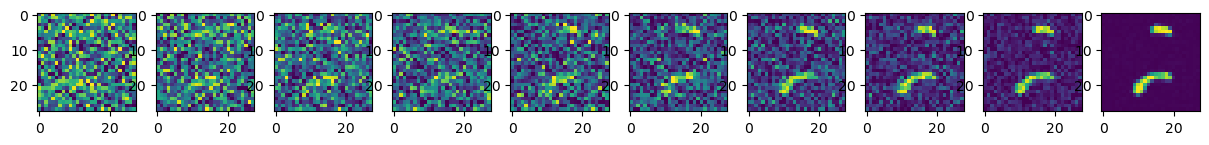

Epoch 11/100, Loss: 0.08422642775671386
Epoch 12/100, Loss: 0.08321155400284917
Epoch 13/100, Loss: 0.0817692196713044
Epoch 14/100, Loss: 0.08136987379127807
Epoch 15/100, Loss: 0.08063186426739116
Epoch 15 | Loss: 0.08230762183666229 


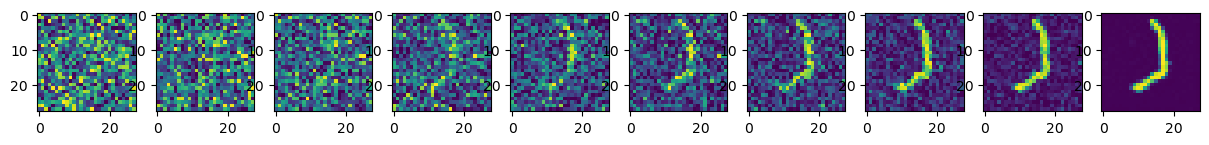

Epoch 16/100, Loss: 0.07975962329587657
Epoch 17/100, Loss: 0.078799613011189
Epoch 18/100, Loss: 0.07846268237783359
Epoch 19/100, Loss: 0.07779703676809759
Epoch 20/100, Loss: 0.07729490408366853
Epoch 20 | Loss: 0.07627522945404053 


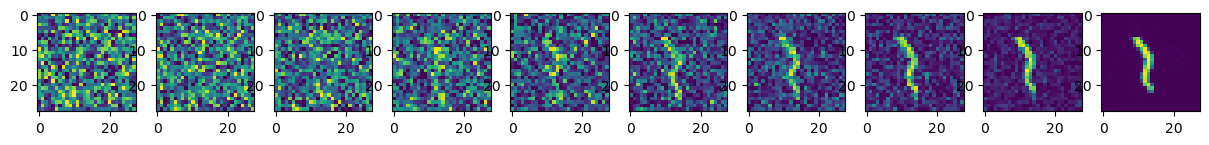

Epoch 21/100, Loss: 0.0762794020930271
Epoch 22/100, Loss: 0.07669376023796015
Epoch 23/100, Loss: 0.0760153975105766
Epoch 24/100, Loss: 0.07577107486489056
Epoch 25/100, Loss: 0.07547790565333523
Epoch 25 | Loss: 0.06906930357217789 


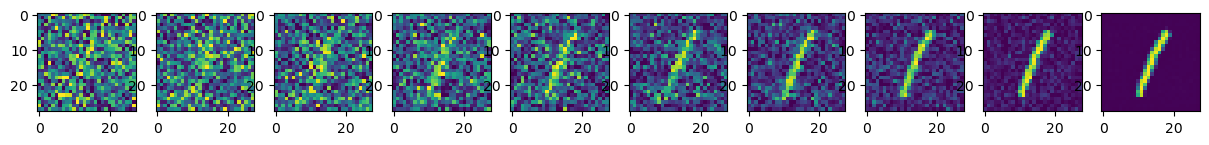

Epoch 26/100, Loss: 0.07497182387462903
Epoch 27/100, Loss: 0.07490627348914251
Epoch 28/100, Loss: 0.07379806815431668
Epoch 29/100, Loss: 0.07386305640304919
Epoch 30/100, Loss: 0.07396012255342016
Epoch 30 | Loss: 0.07154972851276398 


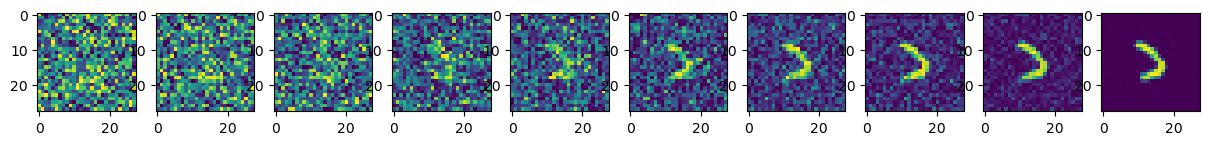

Epoch 31/100, Loss: 0.0732114158379726
Epoch 32/100, Loss: 0.07277385483840447
Epoch 33/100, Loss: 0.07326328672550536
Epoch 34/100, Loss: 0.07327980855172807
Epoch 35/100, Loss: 0.07263707845802708
Epoch 35 | Loss: 0.07135805487632751 


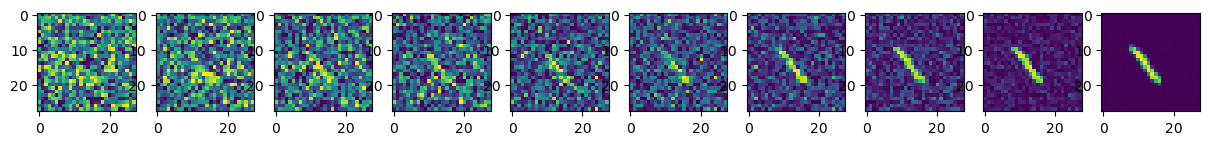

Epoch 36/100, Loss: 0.07251412325944656
Epoch 37/100, Loss: 0.072180055375228
Epoch 38/100, Loss: 0.07229319420871717
Epoch 39/100, Loss: 0.07191844894499569
Epoch 40/100, Loss: 0.07195935474756436
Epoch 40 | Loss: 0.07187382131814957 


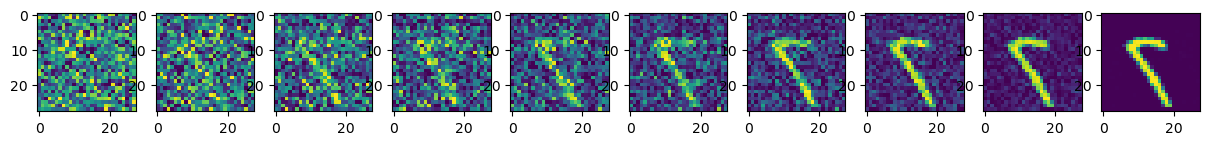

Epoch 41/100, Loss: 0.07174204804358028
Epoch 42/100, Loss: 0.07162190155013577
Epoch 43/100, Loss: 0.07116626354527998
Epoch 44/100, Loss: 0.070494690179934
Epoch 45/100, Loss: 0.07070802172625458
Epoch 45 | Loss: 0.06671638786792755 


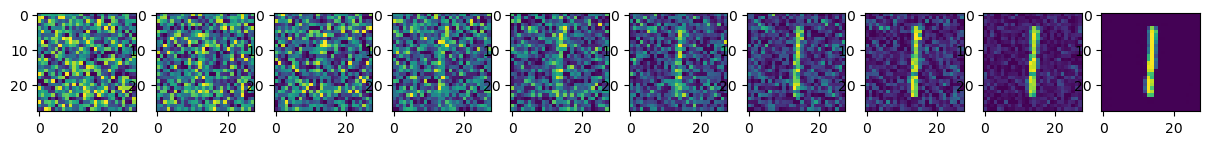

Epoch 46/100, Loss: 0.07074352542804929
Epoch 47/100, Loss: 0.07045553790425861
Epoch 48/100, Loss: 0.07098869025543496
Epoch 49/100, Loss: 0.07004557952503145
Epoch 50/100, Loss: 0.07008227839001588
Epoch 50 | Loss: 0.07312388718128204 


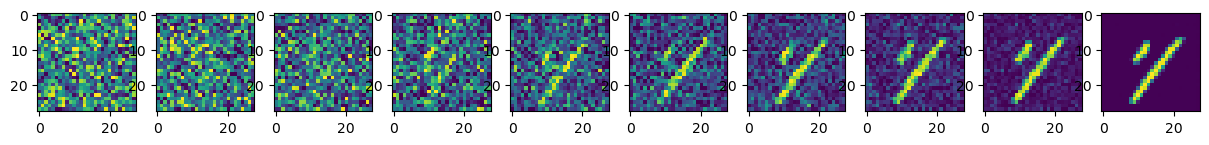

Epoch 51/100, Loss: 0.07040847665306195
Epoch 52/100, Loss: 0.06982965954330378
Epoch 53/100, Loss: 0.07014068022998043
Epoch 54/100, Loss: 0.06905691026140263
Epoch 55/100, Loss: 0.06979871622453897
Epoch 55 | Loss: 0.06854633241891861 


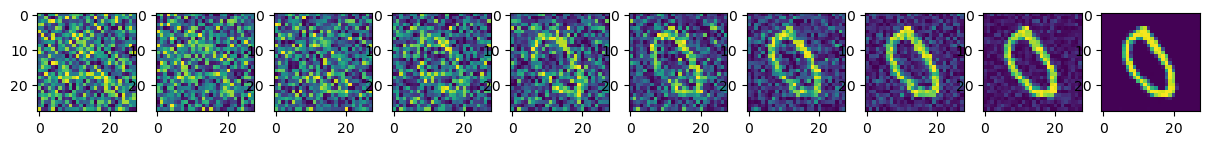

Epoch 56/100, Loss: 0.06957066080945752
Epoch 57/100, Loss: 0.06968268526260887
Epoch 58/100, Loss: 0.06946299027228531
Epoch 59/100, Loss: 0.0691953144025999
Epoch 60/100, Loss: 0.06932049637639916
Epoch 60 | Loss: 0.06316473335027695 


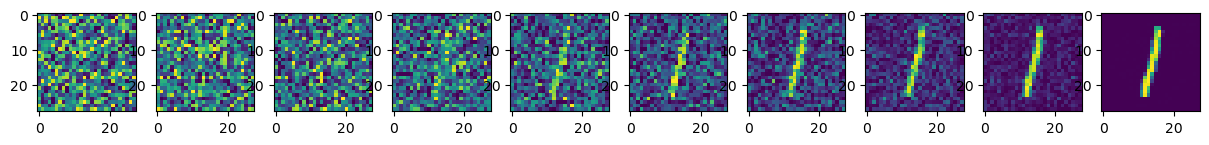

Epoch 61/100, Loss: 0.0690975506336261
Epoch 62/100, Loss: 0.06883366550608869
Epoch 63/100, Loss: 0.06930618290362996
Epoch 64/100, Loss: 0.06897802602486078
Epoch 65/100, Loss: 0.06872735643970879
Epoch 65 | Loss: 0.07330657541751862 


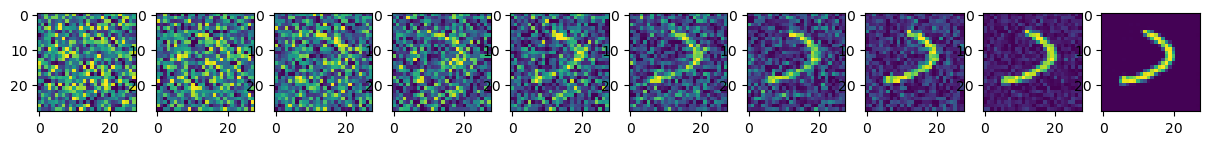

Epoch 66/100, Loss: 0.06821198534261394
Epoch 67/100, Loss: 0.06890700374057879
Epoch 68/100, Loss: 0.06869873885515627
Epoch 69/100, Loss: 0.0685248729728517
Epoch 70/100, Loss: 0.06888144579971885
Epoch 70 | Loss: 0.07068357616662979 


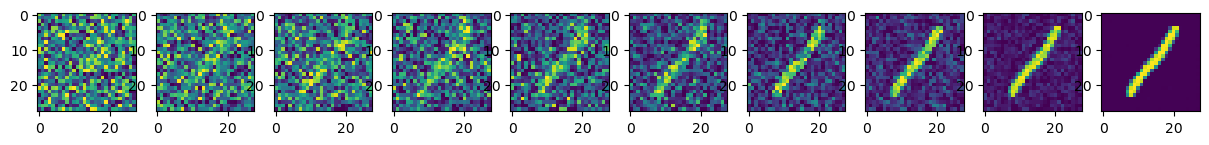

Epoch 71/100, Loss: 0.06788053814553734
Epoch 72/100, Loss: 0.068508379154535
Epoch 73/100, Loss: 0.06813796367428024
Epoch 74/100, Loss: 0.06799439998555096
Epoch 75/100, Loss: 0.06801474362529897
Epoch 75 | Loss: 0.06755996495485306 


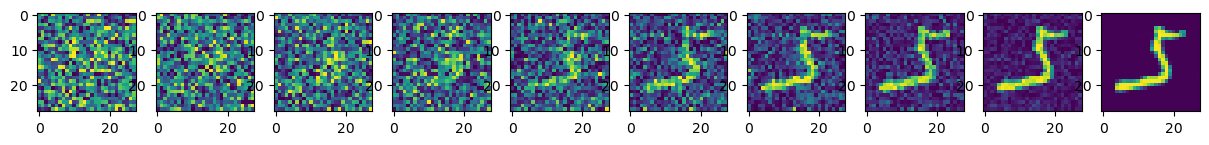

Epoch 76/100, Loss: 0.06769484383883057
Epoch 77/100, Loss: 0.067866392617861
Epoch 78/100, Loss: 0.06799452448256942
Epoch 79/100, Loss: 0.06718443172400469
Epoch 80/100, Loss: 0.06775454695817533
Epoch 80 | Loss: 0.06433907151222229 


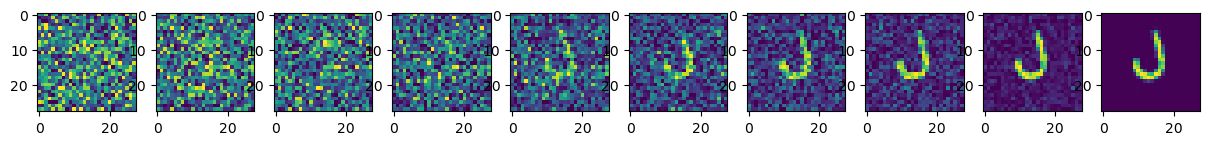

Epoch 81/100, Loss: 0.06728576821694662
Epoch 82/100, Loss: 0.0673686638883837
Epoch 83/100, Loss: 0.06759617945022417
Epoch 84/100, Loss: 0.06734174623703346
Epoch 85/100, Loss: 0.06768244910207423
Epoch 85 | Loss: 0.06771490722894669 


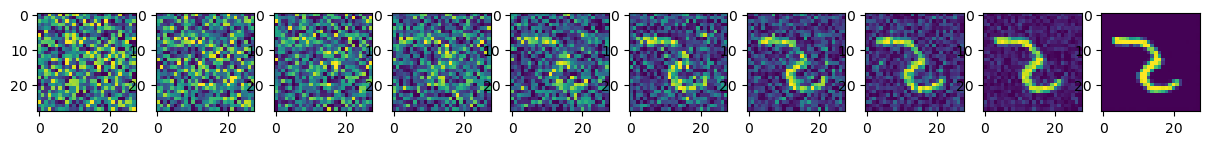

Epoch 86/100, Loss: 0.06757907365404424
Epoch 87/100, Loss: 0.06741153697855089
Epoch 88/100, Loss: 0.06745152449706099
Epoch 89/100, Loss: 0.06758148972313482
Epoch 90/100, Loss: 0.06734264412751564
Epoch 90 | Loss: 0.06789757311344147 


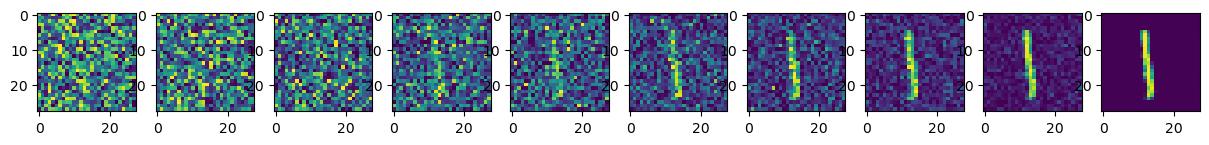

Epoch 91/100, Loss: 0.06720631328776425
Epoch 92/100, Loss: 0.06723684399310267
Epoch 93/100, Loss: 0.06662158376704423
Epoch 94/100, Loss: 0.06700132594822528
Epoch 95/100, Loss: 0.06703805207742221
Epoch 95 | Loss: 0.06601637601852417 


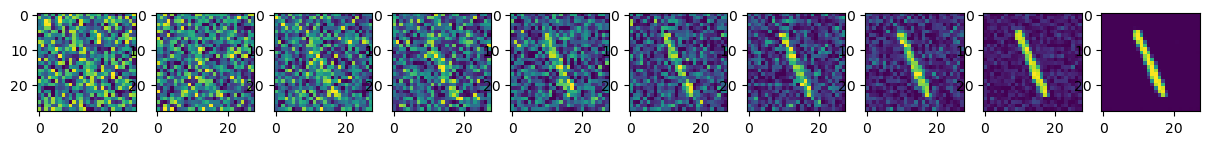

Epoch 96/100, Loss: 0.06678962871268555
Epoch 97/100, Loss: 0.0671131798362994
Epoch 98/100, Loss: 0.06694470850866793
Epoch 99/100, Loss: 0.06703577763759173
Epoch 100/100, Loss: 0.06644320058134887
CPU times: total: 2h 27min 11s
Wall time: 2h 25min 12s


In [12]:
%%time
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 # Change this

losses = []
for epoch in range(epochs):
    total_loss = 0
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      # Algorithm 1 line 3 - sample t uniformly for every example in the batch
      t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()

      loss = get_loss(model, batch[0], t, 'l1')
      loss.backward()
      optimizer.step()
      total_loss += loss.item()

      if epoch % 5 == 0 and step == 0:
        print(f"Epoch {epoch} | Loss: {loss.item()} ")
        plot_sample() # just to look to see progress in training
      
    epoch_loss = total_loss / len(dataloader)
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}")

In [13]:
def save_model(model):
    torch.save(model.state_dict(), "./model.pth")

def load_model(model):
    model.load_state_dict(torch.load("./model.pth"))

In [14]:
# save_model(model)

## 3. Results

### 3.1 Plot and Visual Results

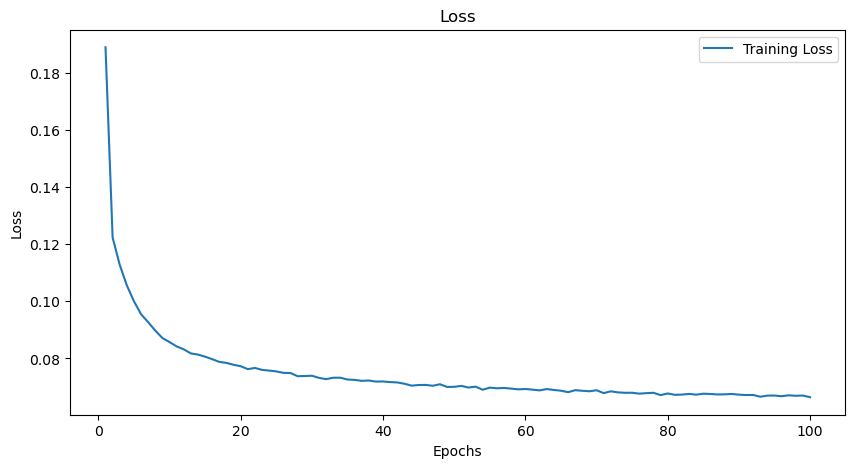

In [15]:
# Plotting the training loss
N = np.arange(epochs) + 1
plt.figure(figsize=(10, 5))
plt.plot(N, losses, label='Training Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Generate New Images

C:\Users\baseb\AppData\Local\Temp\ipykernel_47788\3787241334.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, n, i+1)


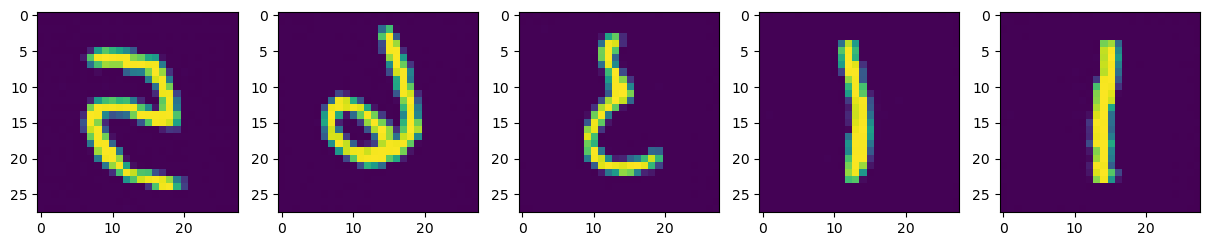

In [16]:
@torch.no_grad()
def generate_image(noise):
    "Generate new image from trained U-Net"
    image = noise

    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        image = sample_timestep(image, t)
        image = torch.clamp(image, -1.0, 1.0)
        if i == 0:
          return image

n = 5
plt.figure(figsize=(15,15))
plt.axis('off')
for i in range(0,n):
    noise = torch.randn((1, 1, IMG_SIZE, IMG_SIZE), device=device)
    image = generate_image(noise)
    plt.subplot(1, n, i+1)
    show_tensor_image(image.detach().cpu())
plt.show()